In [1]:
import jsonlines
from collections import defaultdict
import openai
import json
import regex
from typing import Dict, Any, Tuple
from tqdm import tqdm 

import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import pprint

In [2]:
train_data = defaultdict(list)
test_data = defaultdict(list)

for i in range(5):
    with jsonlines.open(f'train_{i}.jsonl') as f:
        for line in f.iter():
            train_data[i].append(line)

    with jsonlines.open(f'test_{i}.jsonl') as f:
        for line in f.iter():
            test_data[i].append(line)

In [3]:
time_dict = {
    'days': 24,
    'day': 24,
    'weeks': 24*7,
    'week': 24*7,
    'hours': 1,
    'hour': 1,
    'h': 1,
    'minute': 1/60,
    'min': 1/60,
    's': 1/3600
}

In [4]:
class Metric(object):
    def __init__(self):
        self.n_true = 0
        self.n_false = 0
        self.tag_true = defaultdict(int)
        self.tag_false = defaultdict(int)

    def update(self, answer: bool, tag=None):
        if answer:
            self.n_true += 1
            if tag:
                self.tag_true[tag] += 1
        else:
            self.n_false += 1
            if tag:
                self.tag_false[tag] += 1

    def update_list(self, true_list, pred_list, tag=None):
        if not isinstance(true_list, list) or not isinstance(pred_list, list):
            if true_list == pred_list:
                self.n_true += 1
                if tag:
                    self.tag_true[tag] += 1
            else:
                self.n_false += 1
                if tag:
                    self.tag_false[tag] += 1
            return 

        for ls in pred_list:
            if ls in true_list:
                self.n_true += 1
                if tag:
                    self.tag_true[tag] += 1
            else:
                self.n_false += 1
                if tag:
                    self.tag_false[tag] += 1

    def update_temp(self, true, pred):
        eps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        if not isinstance(true, str) or not isinstance(pred, str):
            if true == pred:
                self.n_true += 1
                self.tag_true['temperature'] += 1
                for e in eps:
                    self.tag_true[f'temperature-{e}'] += 1

            else:
                self.n_false += 1
                self.tag_false['temperature'] += 1
                for e in eps:
                    self.tag_false[f'temperature-{e}'] += 1
            return

        if '°C' not in true or '°C' not in pred:
            if true == pred:
                self.n_true += 1
                self.tag_true['temperature'] += 1
                for e in eps:
                    self.tag_true[f'temperature-{e}'] += 1

            else:
                self.n_false += 1
                self.tag_false['temperature'] += 1
                for e in eps:
                    self.tag_false[f'temperature-{e}'] += 1
            return

        true = float(true.replace('°C', '').strip())
        pred = float(pred.replace('°C', '').strip())

        if abs(true-pred) <= 10:
            self.n_true += 1
            self.tag_true['temperature'] += 1
        else:
            self.n_false += 1
            self.tag_false['temperature'] += 1

        for e in eps:
            if abs(true-pred) <= e:
                self.tag_true[f'temperature-{e}'] += 1
            else:
                self.tag_false[f'temperature-{e}'] += 1

    def update_time(self, true, pred):
        if not isinstance(true, str) or not isinstance(pred, str):
            if true == pred:
                self.n_true += 1
                self.tag_true['time'] += 1
            else:
                self.n_false += 1
                self.tag_false['time'] += 1
            return
        
        unit_true = regex.search(r"(?<=\b|\d)(days|day|weeks|week|hours|hour|h|minute|min|s)\b", str(true))
        unit_pred = regex.search(r"(?<=\b|\d)(days|day|weeks|week|hours|hour|h|minute|min|s)\b", str(pred))

        if not unit_pred or not unit_true:
            if true == pred:
                self.n_true += 1
                self.tag_true['time'] += 1
            else:
                self.n_false += 1
                self.tag_false['time'] += 1
            return

        times_true = time_dict[unit_true.group()]
        times_pred = time_dict[unit_pred.group()]

        true = float(true.split()[0]) * times_true + 1e-6
        pred = float(pred.split()[0]) * times_pred + 1e-6

        if true/pred < 2 and true/pred > 0.5:
            self.n_true += 1
            self.tag_true['time'] += 1
        else:
            self.n_false += 1
            self.tag_false['time'] += 1
        
    def update_pressure(self, true: str, pred: str):
        if not isinstance(true, str) or not isinstance(pred, str):
            if true == pred:
                self.n_true += 1
                self.tag_true['pressure'] += 1
            else:
                self.n_false += 1
                self.tag_false['pressure'] += 1
            return
        
        if 'atm' not in true or 'atm' not in pred:
            if true == pred:
                self.n_true += 1
                self.tag_true['pressure'] += 1
            else:
                self.n_false += 1
                self.tag_false['pressure'] += 1
            return

        true = float(true.replace('atm', '').strip())
        pred = float(pred.replace('atm', '').strip())

        if abs(true-pred) <= 1:
            self.n_true += 1
            self.tag_true['pressure'] += 1
        else:
            self.n_false += 1
            self.tag_false['pressure'] += 1

    def accuracy(self, ):
        return self.n_true / (self.n_true + self.n_false)
    
    def accuracy_task(self, ):
        output = dict()
        for key in self.tag_true:
            n_true = self.tag_true[key]
            n_false = self.tag_false[key]
            acc = n_true / (n_true + n_false)
            output[key] = acc
        return output


def evaluate(true, prediction, metric: Metric):
    if not isinstance(prediction, dict):
        metric.update(False)
        return
    # precursor
    try:
        metric.update_list(true.get('precursors', None), prediction.get('precursors', None), tag='precursor')
    except Exception as e:
        metric.update(False, tag='precursor')

    # solvent
    try:
        metric.update_list(true['solvent'], prediction['solvent'], tag='solvent')
    except:
        metric.update(False, tag='solvent')
    
    # conditions
    metric.update_temp(true.get('temperature', None), prediction.get('temperature', None))
    metric.update_time(true.get('time'), prediction.get('time'))

    pressure = prediction.get('pressure')
    if pressure == 'autogenous pressure':
        pressure = 'autogenous'
    metric.update_pressure(true.get('pressure'), pressure)

    # method
    synthesis_method = prediction.get('synthesis_method')
    if synthesis_method == 'solvothermal':
        synthesis_method = 'solvothermal synthesis'
    metric.update(true.get('synthesis_method') == synthesis_method, tag='method')
    metric.update(true.get('cooling') == prediction.get('cooling'), tag='method')
    metric.update_list(true.get('washing'), prediction.get('washing'), tag='method')
    metric.update(true.get('filtration') == prediction.get('filtration'), tag='method')
    metric.update(true.get('drying') == prediction.get('drying'), tag='method')


In [5]:
with open('true_label_save.pickle', 'rb') as f:
    true_label = pickle.load(f)

with open('prediction_label_save.pickle', 'rb') as f:
    prediction_label = pickle.load(f)

In [6]:
result_dict = defaultdict(list)

for key in true_label.keys():
    true, prediction = true_label[key], prediction_label[key]

    print (key)
    for t, p in zip(true, prediction):
        if t is None or p is None:
            continue
        metric = Metric()
        evaluate(t, p, metric)
        result_dict[key].append(metric.accuracy())


gpt3.5-0
gpt4-0


In [7]:
result_dict.keys()
import numpy as np
np.median(result_dict['gpt3.5-0']), np.median(result_dict['gpt4-0'])

(0.8333333333333334, 0.8333333333333334)

In [8]:
with open('true_label_fewshot_gpt3_save.pickle', 'rb') as f:
    true_gpt3 = pickle.load(f)

with open('prediction_label_fewshot_gpt3_save.pickle', 'rb') as f:
    prediction_gpt3 = pickle.load(f)
    
for t, p in zip(true_gpt3, prediction_gpt3):
    metric = Metric()
    evaluate(t, p, metric)
    result_dict['gpt-3.5-fewshot'].append(metric.accuracy())

In [9]:
with open('true_label_fewshot100_gpt3_save.pickle', 'rb') as f:
    true_gpt3 = pickle.load(f)

with open('prediction_label_fewshot100_gpt3_save.pickle', 'rb') as f:
    prediction_gpt3 = pickle.load(f)
    
for t, p in zip(true_gpt3, prediction_gpt3):
    metric = Metric()
    evaluate(t, p, metric)
    result_dict['gpt-3.5-fewshot-100'].append(metric.accuracy())

In [10]:
with open('true_label_zeroshot_gpt3_save.pickle', 'rb') as f:
    true_gpt3 = pickle.load(f)

with open('prediction_label_zeroshot_gpt3_save.pickle', 'rb') as f:
    prediction_gpt3 = pickle.load(f)
    
for t, p in zip(true_gpt3, prediction_gpt3):
    metric = Metric()
    evaluate(t, p, metric)
    result_dict['gpt-3.5-zeroshot'].append(metric.accuracy())

In [12]:
with open('true_label_fewshot_gpt4o_save.pickle', 'rb') as f:
    true_gpt4o = pickle.load(f)

with open('prediction_label_fewshot_gpt4o_save.pickle', 'rb') as f:
    prediction_gpt4o = pickle.load(f)
    
for t, p in zip(true_gpt4o, prediction_gpt4o):
    metric = Metric()
    evaluate(t, p, metric)
    result_dict['gpt-4o-fewshot'].append(metric.accuracy())

In [13]:
with open('true_label_zeroshot_gpt4o_save.pickle', 'rb') as f:
    true_gpt4o = pickle.load(f)

with open('prediction_label_zeroshot_gpt4o_save.pickle', 'rb') as f:
    prediction_gpt4o = pickle.load(f)
    
for t, p in zip(true_gpt4o, prediction_gpt4o):
    metric = Metric()
    evaluate(t, p, metric)
    result_dict['gpt-4o-zeroshot'].append(metric.accuracy())

In [14]:
with open('true_label_fewshot100_gpt4o_save.pickle', 'rb') as f:
    true_gpt3 = pickle.load(f)

with open('prediction_label_fewshot100_gpt4o_save.pickle', 'rb') as f:
    prediction_gpt3 = pickle.load(f)
    
for t, p in zip(true_gpt3, prediction_gpt3):
    metric = Metric()
    evaluate(t, p, metric)
    result_dict['gpt-4o-fewshot-100'].append(metric.accuracy())

In [15]:
with open('true_label_random_save.pickle', 'rb') as f:
    true_random = pickle.load(f)

with open('prediction_label_random_save.pickle', 'rb') as f:
    prediction_random = pickle.load(f)

In [16]:
for t, p in zip(true_random, prediction_random):
    metric = Metric()
    evaluate(t, p, metric)
    result_dict['random'].append(metric.accuracy())

In [17]:
with open('true_label_random_feq_save.pickle', 'rb') as f:
    true_feq_random = pickle.load(f)

with open('prediction_label_random_feq_save.pickle', 'rb') as f:
    prediction_feq_random = pickle.load(f)

In [18]:
for t, p in zip(true_feq_random, prediction_feq_random):
    metric = Metric()
    evaluate(t, p, metric)
    result_dict['random_feq'].append(metric.accuracy())

In [19]:
name_dict = {
    'gpt4-0': 'GPT-4o', 
    'gpt3.5-0': 'GPT-3.5', 
    'gpt-4o-zeroshot': 'GPT-4o',
    'gpt-3.5-zeroshot': 'GPT-3.5',
    'gpt-4o-fewshot': 'GPT-4o', 
    'gpt-3.5-fewshot': 'GPT-3.5', 
    'gpt-4o-fewshot-100': 'GPT-4o',
    'gpt-3.5-fewshot-100': 'GPT-3.5',
    'random': 'Random',
    'random_feq': 'Statistic'
}

color=['#CF796A', '#CF796A', '#658CC8', '#658CC8', '#6AB55F', '#6AB55F', '#C7A663', '#C7A663', '#999999', '#999999']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


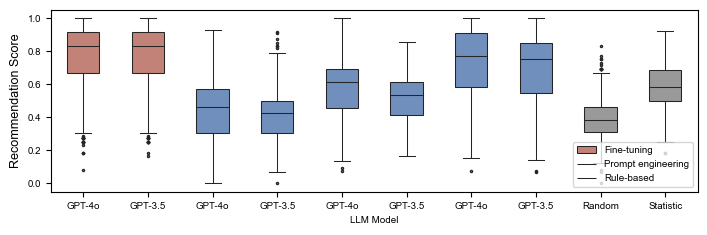

In [20]:
mm = 0.0393701
color=['#CF796A', '#CF796A', '#658CC8', '#658CC8', '#658CC8', '#658CC8', '#658CC8', '#658CC8', '#999999', '#999999']

plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 7

#fig, ax = plt.subplots(1, 1, figsize=(115* mm, 60* mm))
fig, ax = plt.subplots(1, 1, figsize=(180* mm, 60* mm))

for i, key in enumerate(name_dict.keys()):
    value = result_dict[key]
    sns.boxplot(x=i, y=value, color=color[i], width=0.5, linecolor='#252525', linewidth=0.75, fliersize=1.5)

plt.xticks(range(len(name_dict)), name_dict.values())
plt.xlabel('LLM Model', fontsize=7)
plt.ylabel('Recommendation Score', fontsize=9)

plt.legend(['Fine-tuning', 'Prompt engineering', 'Rule-based'], loc='lower right')

plt.tight_layout()

plt.savefig('llm.eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


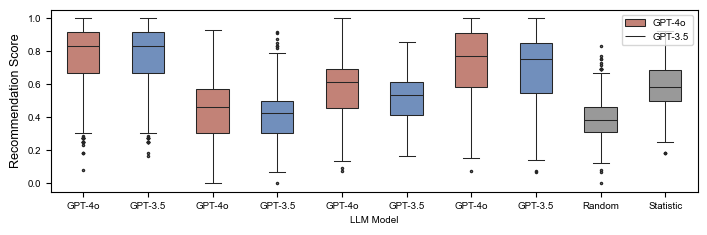

In [ ]:
mm = 0.0393701
color=['#CF796A',  '#658CC8', '#CF796A',  '#658CC8', '#CF796A',  '#658CC8', '#CF796A',  '#658CC8',  '#999999', '#999999']

plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 7

# fig, ax = plt.subplots(1, 1, figsize=(115* mm, 60* mm))
fig, ax = plt.subplots(1, 1, figsize=(180* mm, 60* mm))

for i, key in enumerate(name_dict.keys()):
    value = result_dict[key]
    sns.boxplot(x=i, y=value, color=color[i], width=0.5, linecolor='#252525', linewidth=0.75, fliersize=1.5)

plt.xticks(range(len(name_dict)), name_dict.values())
plt.xlabel('LLM Model', fontsize=7)
plt.ylabel('Recommendation Score', fontsize=9)
plt.legend(['GPT-4o',t 'GPT-3.5'], loc='upper right')
plt.tight_layout()

plt.savefig('llm2.eps', bbox_inches='tight')
plt.show()

In [26]:
metric_output = dict()
for key in true_label.keys():
    true, prediction = true_label[key], prediction_label[key]

    metric_task = Metric()
    for t, p in zip(true, prediction):
        if t is None or p is None:
            continue
        #metric = Metric()
        evaluate(t, p, metric_task)

    metric_output[key] = metric_task
        


In [27]:
metric_output['gpt4-0'].accuracy_task()

{'precursor': 0.9911081837642022,
 'solvent': 0.6830559757942511,
 'temperature': 0.4933142311365807,
 'temperature-10': 0.4933142311365807,
 'temperature-20': 0.6150907354345749,
 'temperature-30': 0.6528175740210124,
 'temperature-40': 0.7263610315186246,
 'temperature-50': 0.7483285577841452,
 'temperature-60': 0.779847182425979,
 'temperature-70': 0.8046800382043935,
 'temperature-80': 0.8271251193887297,
 'temperature-90': 0.839541547277937,
 'temperature-100': 0.887774594078319,
 'time': 0.5950334288443171,
 'method': 0.7885546170636804,
 'pressure': 0.774116523400191}

In [28]:
i

9

In [29]:
name_dict = {
    'method': 'Synthesis\nmethod',
    'solvent': 'Solvent',
    'temperature': 'Temp',
    'time': 'Time',
    'pressure': 'Pressure',
    #'cooling': 'cooling',
    #'washing': 'washing',
    #'filtration': 'filtration',
    #'drying': 'drying',



}

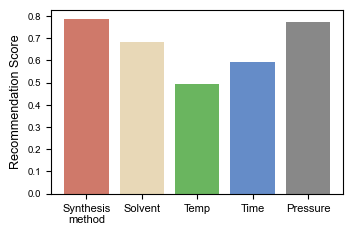

In [ ]:
model = 'gpt4-0'
mm = 0.0393701
#color=['#CF796A',  '#658CC8', '#CF796A',  '#658CC8', '#CF796A',  '#658CC8', '#CF796A',  '#658CC8',  '#999999', '#999999']
# color = ['#999999'] * len(name_dict)
color = ['#CF796A', '#E8D8B7', '#6AB55F', '#658CC8', '#888888']

plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 7

fig, ax = plt.subplots(1, 1, figsize=(90* mm, 60* mm))

value_dict = metric_output[model].accuracy_task()

for i, key in enumerate(name_dict.keys()):
    value = value_dict[key]
    #value = result_dict[key]
    #sns.boxplot(x=i, y=value, color=color[i], width=0.5, linecolor='#252525', linewidth=0.75, fliersize=1.5)
    plt.bar(x=i, height=value, color=color[i])

plt.xticks(range(len(name_dict)), name_dict.values(), fontsize=8)
#plt.xlabel('LLM Model', fontsize=7)
plt.ylabel('Recommendation Score', fontsize=9)
# plt.legend(['GPT-4o', 'GPT-3.5'], loc='upper right')
plt.tight_layout()

plt.savefig('feature_importance.eps', bbox_inches='tight')
plt.show()